In [1]:
import re
import numpy as np
import numpy.random as npr
from scipy.stats import mode
from scipy.special import gammaln, digamma, logsumexp
from scipy.stats import dirichlet as dir
from scipy.stats import multinomial as multinom
from tqdm import tqdm
import matplotlib.pyplot as plt

def clean_text(text):
    with open("vocab.txt", "r") as file:
        vocab = [line.strip() for line in file.readlines()]
    vocab_set = set(vocab)
    contractions = {
        r"n\'t": 'nt',
        r"\'s": 's',     
        r"\'ve": 've',   
        r"\'re": 're',   
        r"\'m": 'm',     
        r"\'ll": 'll',   
        r"\'d": 'd'      
    }

    text = text.lower().strip()
    text = re.sub(r'[.,!?;:"``]', " ", text)
    words = []
    for word in text.split():
        if "'" in word:
            word_added = False
            for pattern, replacement in contractions.items():
                if word.endswith(pattern):
                    contracted = word.replace(pattern, replacement)
                    if contracted in vocab_set:
                        words.append(contracted)
                        word_added = True
                        break
            if not word_added:
                combined = word.replace("'", "")
                if combined in vocab_set:
                    words.append(combined)
        if "-" in word:
            combined = word.replace("-", "")
            if combined in vocab_set:
                words.append(combined)
                continue 
            parts = [p for p in word.split("-") if p in vocab_set]
            words.extend(parts)
        else:
            if word in vocab_set:
                words.append(word)
    return words

rs = npr.RandomState(0)
K, V, N = 10, 300, 30
eta0, alpha0 = 0.8, 1 / K
Ms = rs.poisson(60, size=N)

In [100]:
def generate_lda(K, V, N, Ms, eta0=(1 / K), alpha0=(1 / K), rs_int=npr.randint(low=0, high=100)):
    eta0_vec = np.ones(V) * eta0
    alpha0_vec = np.ones(K) * alpha0

    beta = dir.rvs(eta0_vec, size=K)
    theta = dir.rvs(alpha0_vec, size=N)
    X = []
    for i in range(N):
        x_i = np.zeros(Ms[i], dtype=int)
        for j in range(Ms[i]):
            z_ij = np.argmax(multinom.rvs(1, p=theta[i]))
            x_ij = np.argmax(multinom.rvs(1, p=beta[z_ij]))
            x_i[j] = x_ij
        X.append(x_i)
    return X

def init_var_params(X, K, V, rs_int=npr.randint(low=0, high=100)):
    rs = npr.RandomState(rs_int)
    N = len(X)
    log_lambd = np.log(rs.uniform(low=0.1, high=1.0, size=(K, V)))
    log_gamma = np.log(rs.uniform(low=0.1, high=1.0, size=(N, K)))
    return log_lambd, log_gamma

def sample_params(var_params, rs_int=npr.randint(low=0, high=100)):
    rs = npr.RandomState(rs_int)
    log_lambd, log_gamma = var_params
    beta = np.zeros_like(log_lambd)
    theta = np.zeros_like(log_gamma)
    # for k in range(K):
    #     beta[k] = dir.rvs(np.exp(log_lambd[k]), random_state=rs_int)[0]
        # beta[k] = rs.dirichlet(np.exp(log_lambd[k]))
    # for i in range(N):
    #     theta[i] = dir.rvs(np.exp(log_gamma[i]), random_state=rs_int)[0]
        # theta[i] = rs.dirichlet(np.exp(log_gamma[i]))
    log_gamm_beta = np.log(npr.gamma(np.exp(log_lambd), 1))
    log_probs_beta = log_gamm_beta - logsumexp(log_gamm_beta, axis=1)[:, None]
    beta = np.exp(log_probs_beta)
    log_gamm_gamma = np.log(npr.gamma(np.exp(log_gamma), 1))
    log_probs_gamma = log_gamm_gamma - logsumexp(log_gamm_gamma, axis=1)[:, None]
    theta = np.exp(log_probs_gamma)
    
    return beta, theta

def log_var_approx(var_params, latent_params):
    log_lambd, log_gamma = var_params
    beta, theta = latent_params
    K = log_lambd.shape[0]
    N = log_gamma.shape[0]

    log_q_beta = sum(dir.logpdf(beta[k], np.exp(log_lambd[k])) for k in range(K))
    log_q_theta = sum(dir.logpdf(theta[i], np.exp(log_gamma[i])) for i in range(N))
    return float(log_q_beta + log_q_theta)

def log_joint_prob(latent_params, X):
    beta, theta = latent_params
    K, V = beta.shape
    N = theta.shape[0]
    eta0_vec = np.ones(V) * eta0
    alpha0_vec = np.ones(K) * alpha0

    log_p_beta = sum(dir.logpdf(beta[k], eta0_vec) for k in range(K))
    log_p_theta = sum(dir.logpdf(theta[i], alpha0_vec) for i in range(N))
    log_p_x = 0.0
    for _, (theta_i, x_i) in enumerate(zip(theta, X)):
        beta_xi = beta[:, x_i]
        log_word_probs = np.log(np.sum(theta_i[:, None] * beta_xi, axis=0))
        log_p_x += np.sum(log_word_probs)
    return float(log_p_beta + log_p_theta + log_p_x)

def score_dir(x, alpha):
    return digamma(np.sum(alpha)) - digamma(alpha) + np.log(x)

def score_var_dist(var_params, latent_params):
    log_lambd, log_gamma = var_params
    beta, theta = latent_params
    grad_lambd = (digamma(np.sum(np.exp(log_lambd), axis=0)) - digamma(np.exp(log_lambd)) + np.log(beta)) * np.exp(log_lambd)
    grad_gamma = (digamma(np.sum(np.exp(log_gamma), axis=0)) - digamma(np.exp(log_gamma)) + np.log(theta)) * np.exp(log_gamma)
    return grad_lambd, grad_gamma

def estimate_ELBO(var_params, X, S):
    log_lambd, log_gamma = var_params
    ELBO = 0.0
    for _ in range(S):
        beta_s, theta_s = sample_params((log_lambd, log_gamma))
        log_p = log_joint_prob((beta_s, theta_s), X)
        log_q = log_var_approx((log_lambd, log_gamma), (beta_s, theta_s))
        ELBO += (log_p - log_q)
    return ELBO / S

In [122]:
def init_var_params(X, K, V, rs_int=npr.randint(low=0, high=100)):
    rs = npr.RandomState(rs_int)
    N = len(X)
    log_lambd = np.log(rs.uniform(low=0.3, high=1.0, size=(K, V)))
    log_gamma = np.log(rs.uniform(low=0.3, high=1.0, size=(N, K)))
    return log_lambd, log_gamma

rs = npr.RandomState(0)
K, V, N = 10, 300, 30
eta0, alpha0 = 1 / K, 1 / K
Ms = rs.poisson(60, size=N)
S = 100
lr = 1e-4
eps = 1e-6

X = generate_lda(K, V, N, Ms, eta0=eta0, alpha0=alpha0)
lambd, gamma = init_var_params(X, K, V)
G_lambd, G_gamma = np.zeros_like(lambd), np.zeros_like(gamma)
max_iters = 21

for t in range(max_iters):
    betas = []
    thetas = []
    for _ in range(S):
        beta_s, theta_s = sample_params((lambd, gamma))
        betas.append(beta_s)
        thetas.append(theta_s)

    stoch_score_grad_lambd = np.zeros_like(lambd)
    stoch_score_grad_gamma = np.zeros_like(gamma)
    for s in tqdm(range(S), desc=f"Iteration {t} | Calculating stochastic score gradient"):
        score_lambd, score_gamma = score_var_dist((lambd, gamma), (betas[s], thetas[s]))
        log_p = log_joint_prob((betas[s], thetas[s]), X)
        log_q = log_var_approx((lambd, gamma), (betas[s], thetas[s]))
        stoch_score_grad_lambd += score_lambd * (log_p - log_q)
        stoch_score_grad_gamma += score_gamma * (log_p - log_q)
    stoch_score_grad_lambd /= S
    stoch_score_grad_gamma /= S

    stoch_score_grad_lambd = np.clip(stoch_score_grad_lambd, -100, 100)
    stoch_score_grad_gamma = np.clip(stoch_score_grad_gamma, -100, 100)

    G_lambd += np.power(stoch_score_grad_lambd, 2)
    lambd = lambd + np.multiply((lr / np.power(G_lambd, 0.5)), stoch_score_grad_lambd)

    G_gamma += np.power(stoch_score_grad_gamma, 2)
    gamma = gamma + np.multiply((lr / np.power(G_gamma, 0.5)), stoch_score_grad_gamma)

    if t % 5 == 0:
        print(f"\nMC ELBO: {estimate_ELBO((lambd, gamma), X, S)}\n")

Iteration 0 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 186.61it/s]



MC ELBO: -13229.900704645395



Iteration 1 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 226.77it/s]
Iteration 2 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 246.59it/s]
Iteration 3 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 244.05it/s]
Iteration 4 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 233.75it/s]
Iteration 5 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 216.58it/s]



MC ELBO: -13238.28590415385



Iteration 6 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 236.33it/s]
Iteration 7 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 237.80it/s]
Iteration 8 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 236.84it/s]
Iteration 9 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 216.20it/s]
Iteration 10 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 244.26it/s]



MC ELBO: -13227.803020040255



Iteration 11 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 239.71it/s]
Iteration 12 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 247.90it/s]
Iteration 13 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 236.14it/s]
Iteration 14 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 221.52it/s]
Iteration 15 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 242.85it/s]



MC ELBO: -13227.100151368619



Iteration 16 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 241.89it/s]
Iteration 17 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 242.66it/s]
Iteration 18 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 235.29it/s]
Iteration 19 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 243.60it/s]
Iteration 20 | Calculating stochastic score gradient: 100%|██████████| 100/100 [00:00<00:00, 246.78it/s]



MC ELBO: -13230.373878964008



In [140]:
lambd, gamma = init_var_params(X, K, V, 0)
beta_s, theta_s = sample_params((lambd, gamma), 0)
# np.exp(lambd[0, :10]), beta_s
sum(dir.logpdf(beta_s[k], np.ones(V) * eta0) for k in range(K))

np.float64(12300.531746912535)

In [141]:
np.sum(gammaln(V * eta0) - V * gammaln(eta0) + (eta0 - 1) * np.sum(np.log(beta_s), axis=1))

np.float64(12300.531746912537)

In [121]:
beta_s, theta_s = sample_params((lambd, gamma), 0)
# log_p = log_joint_prob((beta_s, theta_s), X)
# log_q = log_var_approx((lambd, gamma), (beta_s, theta_s))
np.exp(lambd[0])

array([0.56240401, 0.96588802, 0.81272224, 0.71934991, 0.4093775 ,
       0.40936061, 0.34079543, 0.90668753, 0.72107017, 0.79597055,
       0.3145355 , 0.9793303 , 0.88306458, 0.44881767, 0.42744919,
       0.42855531, 0.51317572, 0.66759768, 0.60260358, 0.50406288,
       0.72858971, 0.3978055 , 0.504704  , 0.55667691, 0.61949785,
       0.84996461, 0.43994838, 0.66022933, 0.71497741, 0.33264892,
       0.72557286, 0.41953542, 0.34567498, 0.96460737, 0.97633462,
       0.86622611, 0.51343589, 0.36851852, 0.77927616, 0.60835112,
       0.38558166, 0.6468837 , 0.3242022 , 0.93690064, 0.48133934,
       0.76407253, 0.518406  , 0.66431448, 0.68297155, 0.42957068,
       0.97910255, 0.84293159, 0.95803411, 0.92675143, 0.71881874,
       0.94569186, 0.36209021, 0.4373637 , 0.33179239, 0.52794331,
       0.572304  , 0.49014122, 0.88046995, 0.54994825, 0.49685375,
       0.68016048, 0.39880716, 0.86188411, 0.35232698, 0.99121904,
       0.84090914, 0.43927744, 0.3039876 , 0.87117296, 0.79511

In [36]:
log_lambd, log_gamma = init_var_params(X, K, V)
beta, theta = sample_params((log_lambd, log_gamma))
# lambd, gamma = np.exp(lambd), np.exp(gamma)
# (digamma(np.exp(log_lambd)) + np.log(beta)).shape
# (digamma(np.sum(np.exp(log_lambd), axis=0)) - digamma(np.exp(log_lambd)) + np.log(beta)).shape
rs = npr.RandomState(0)
rs.dirichlet(np.exp(log_lambd[0]))

array([9.23126939e-03, 3.71789742e-03, 9.57619936e-03, 1.26453940e-03,
       2.65264607e-03, 3.97772855e-03, 5.08707682e-03, 2.70513069e-03,
       3.46542635e-03, 3.47985507e-03, 8.34025271e-03, 1.83425798e-03,
       2.69465969e-05, 4.88805184e-03, 1.17796759e-02, 7.19113512e-04,
       7.58015902e-03, 7.41680532e-03, 1.19370757e-03, 1.52579319e-04,
       6.93604148e-03, 6.17678757e-03, 1.03091474e-03, 4.05891542e-04,
       1.45152543e-03, 1.76742205e-03, 3.52056943e-04, 2.64942864e-03,
       1.38259638e-03, 4.07573414e-03, 2.19430778e-03, 4.12442383e-03,
       1.78829671e-03, 2.12134010e-03, 1.07361097e-03, 3.44224459e-04,
       6.08050770e-04, 3.69355160e-03, 4.82859176e-03, 3.03657967e-03,
       3.67278207e-03, 1.23910809e-03, 2.40122924e-03, 2.93487695e-03,
       6.87154906e-04, 4.68966270e-03, 3.95102703e-03, 3.52958041e-04,
       6.79200259e-03, 2.47178926e-03, 2.23056091e-03, 5.93496010e-03,
       3.05286988e-03, 4.28527800e-03, 2.87888900e-03, 3.97851280e-03,
      

In [888]:
mode(np.exp(lambd))[0], mode(np.exp(gamma))[0]

(array([0.14061243, 0.17406563, 0.1984927 , 0.11974509, 0.19535953,
        0.25408139, 0.26816687, 0.16332432, 0.12415875, 0.18280832,
        0.53254985, 0.20389916, 0.38340894, 0.12949957, 0.37105881,
        0.10670929, 0.12663039, 0.50994451, 0.1746955 , 0.16872968,
        0.33995287, 0.31366867, 0.13540178, 0.11024554, 0.24649014,
        0.15578735, 0.23348288, 0.18774496, 0.10155597, 0.13325151,
        0.21030046, 0.1893604 , 0.1567818 , 0.11131207, 0.1004659 ,
        0.14121393, 0.17747177, 0.17004826, 0.22737724, 0.12480315,
        0.14275477, 0.20684688, 0.26635756, 0.14091526, 0.16107774,
        0.18618436, 0.18865839, 0.11145348, 0.13674715, 0.3136761 ,
        0.13285916, 0.10546174, 0.12550616, 0.30442718, 0.10674261,
        0.1779896 , 0.2412678 , 0.15305375, 0.10125096, 0.14786152,
        0.13974061, 0.33045793, 0.1327597 , 0.15798993, 0.14308142,
        0.15489698, 0.1124459 , 0.12262518, 0.17633217, 0.10402708,
        0.13962881, 0.10223261, 0.15489596, 0.30

In [ ]:
def log_joint_prob(latent_params, X):
    beta, theta = latent_params
    K, V = beta.shape
    N = theta.shape[0]
    eta0_vec = np.ones(V) * eta0
    alpha0_vec = np.ones(K) * alpha0

    log_p_beta = sum(dir.logpdf(beta[k], eta0_vec) for k in range(K))
    log_p_theta = sum(dir.logpdf(theta[i], alpha0_vec) for i in range(N))
    log_p_x = 0.0
    for _, (theta_i, x_i) in enumerate(zip(theta, X)):
        beta_xi = beta[:, x_i]
        log_word_probs = np.log(np.sum(theta_i[:, None] * beta_xi, axis=0))
        log_p_x += np.sum(log_word_probs)
    return log_p_beta + log_p_theta + log_p_x

In [779]:
log_lambd, log_gamma = np.log(np.ones((K, V)) * 0.1), np.log(np.ones((N, K)) * 0.1)
beta, theta = sample_params((log_lambd, log_gamma))
K, V = beta.shape
N = theta.shape[0]
eta0_vec = np.ones(V) * eta0
alpha0_vec = np.ones(K) * alpha0
log_p_x = 0.0
for _, (theta_i, x_i) in enumerate(zip(theta, X)):
        beta_xi = beta[:, x_i]
        log_word_probs = np.log(np.sum(theta_i[:, None] * beta_xi, axis=1))
        log_p_x += np.sum(log_word_probs)

log_p_x
log_p_beta = sum(dir.logpdf(beta[k], eta0_vec) for k in range(K))
log_p_theta = sum(dir.logpdf(theta[i], alpha0_vec) for i in range(N))

log_p_beta + log_p_theta + log_p_x, log_joint_prob((beta, theta), X), log_var_approx((log_lambd, log_gamma), (beta, theta))

(np.float64(29758.362930108022),
 np.float64(18957.790563315197),
 np.float64(33182.962065412954))

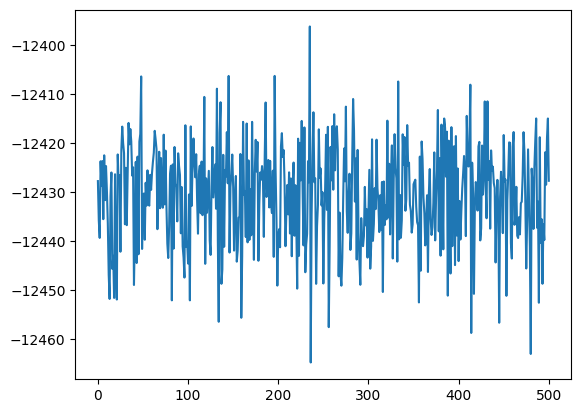

In [719]:
plt.plot(np.arange(max_iters), np.asarray(ELBOs))

In [586]:
rs = npr.RandomState(0)
K, V, N = 10, 300, 30
eta0, alpha0 = 0.1, 5 / K
Ms = rs.poisson(60, size=N)
X = generate_lda(K, V, N, Ms, eta0=eta0, alpha0=alpha0, rs_int=0)
lambd, gamma = init_var_params(X, K, V, 0)
beta, theta = sample_params((lambd, gamma))
log_joint_prob((beta, theta), X), log_var_approx((lambd, gamma), (beta, theta))

(np.float64(1570.6642264909242), np.float64(14972.673387488474))

In [ ]:
S = 10
rs = npr.RandomState(0)
K, V, N = 10, 300, 30
eta0, alpha0 = 0.1, 5 / K
Ms = rs.poisson(60, size=N)
eta = 0.00001
eps = 1e-8
X = generate_lda(K, V, N, Ms, eta0=0.01, alpha0=(5 / K), rs_int=0)
lambd, gamma = init_var_params(X, K, V, 0)
G_lambda = np.zeros((V, V))
G_gamma = np.zeros((K, K))

ELBOs = []
ELBO_init = 0.0
for s in range(S):
    beta_s, theta_s = sample_params((lambd, gamma))
    ELBO_init += log_joint_prob((beta_s, theta_s), X) - log_var_approx((lambd, gamma), (beta_s, theta_s))
print(f"Initial ELBO Estimate: {ELBO_init / S}")
ELBOs.append(ELBO_init)

for t in range(501):
    betas = []
    thetas = []
    grad_lambda = np.zeros_like(lambd)
    grad_gamma = np.zeros_like(gamma)
    for s in range(S):
        beta_s, theta_s = sample_params((lambd, gamma))
        grad_lambda_s, grad_gamma_s = stoch_score_grad((lambd, gamma), (beta_s, theta_s))
        log_p, log_q = log_joint_prob((beta_s, theta_s), X), log_var_approx((lambd, gamma), (beta_s, theta_s))

        grad_lambda += grad_lambda_s * (log_p - log_q)
        grad_gamma += grad_gamma_s * (log_p - log_q)
    grad_lambda /= S
    grad_gamma /= S

    for k in range(K):
        G_lambda += np.outer(grad_lambda[k], grad_lambda[k])
    rho_lambda = eta * (G_lambda.diagonal() + eps)**(-0.5)
    lambd += rho_lambda * grad_lambda
    for i in range(N):
        G_gamma += np.outer(grad_gamma[i], grad_gamma[i])
    rho_gamma = eta * (G_gamma.diagonal() + eps)**(-0.5)
    gamma += rho_gamma * grad_gamma

# G_lambda += grad_lambda * grad_lambda
# rho_lambda = eta * (G_lambda + eps)**(-0.5)
# lambd += rho_lambda * grad_lambda

# G_gamma += grad_gamma * grad_gamma
# rho_gamma = eta * (G_gamma + eps)**(-0.5)
# gamma += rho_gamma * grad_gamma

    ELBO_est = 0.0
    for s in range(S):
        beta_s, theta_s = sample_params((lambd, gamma))
        log_p = log_joint_prob((beta_s, theta_s), X)
        log_q = log_var_approx((lambd, gamma), (beta_s, theta_s))
        ELBO_est += (log_p - log_q)
    ELBOs.append(ELBO_est / S)
    if t % 50 == 0:
        print(f"Iteration {t} | ELBO Estimate: {ELBO_est / S}")

plt.plot(np.arange(0, len(ELBOs)), np.asarray(ELBOs))
# G_lambda += np.square(grad_lambda)
# G_gamma += np.square(grad_gamma)
# rho_lambda = rho / (np.sqrt(G_lambda) + eps)
# rho_gamma = rho / (np.sqrt(G_gamma) + eps)

# lambd += rho_lambda * grad_lambda
# gamma += rho_gamma * grad_gamma

Initial ELBO Estimate: -13376.625584388526
-13181.904574160842
Iteration 0 | ELBO Estimate: -13389.404297708383
-13445.026573833191
-13292.946747126987
-13351.389345770727
-13188.608268843358
-13456.190010973804
-13198.820038708509
-13424.245173566816
-13404.460417379092
-13495.621852282171
-13490.112914749947
-13313.931183301442
-13271.125307887405
-13271.29346346193
-13191.668112719972
-13297.197574788479
-13557.120451769324
-13600.95643203182
-13436.01762321374
-13200.859100119662
-13550.396084753658
-13536.579459945435
-13354.433381749463
-13272.921755892477
-13338.574291442399
-13502.813974590308
-13440.31950832073
-13600.237513304899
-13477.700522277048
-13310.118478619594
-13472.119654287359
-13433.232670427906
-13490.51084191163
-13321.864732287026
-13407.701566009027
-13487.397430774781
-13366.225209186236
-12986.440712734302
-13177.682188845987
-13414.010843302198
-13449.431501147841
-13461.181991411944
-13475.193451461015
-13208.757225930494
-13350.70935889908
-13386.4082458

KeyboardInterrupt: 

In [439]:
lambd, gamma = init_var_params(X, K, V)
beta, theta = sample_params((lambd, gamma))

K = beta.shape[0]
N = theta.shape[0]
log_p_beta = sum(dir.logpdf(beta[k], np.full(beta[k].shape, eta0)) for k in range(K))
log_p_theta = sum(dir.logpdf(theta[i], np.full(theta[i].shape, alpha0)) for i in range(N))

etas = np.ones(V) * eta0
gammaln(np.sum(etas)) - np.sum(gammaln(etas)) + np.sum((etas - 1) * np.log(beta[0]))

np.float64(1490.0376929100237)

In [448]:
log_joint_prob((beta, theta), X)

np.float64(3423.9505787750622)

In [449]:
log_p_x = 0.0
for i, (theta_i, x_i) in enumerate(zip(theta, X)):
    beta_xi = beta[:, x_i]
    sum_word_probs = np.sum(np.log(theta_i[:, None] * beta_xi), axis=0)
    log_p_x += np.sum(sum_word_probs)
log_p_x + log_p_beta + log_p_theta - log_var_approx((lambd, gamma), (beta, theta))

np.float64(-208753.6964655366)

In [876]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string

with open("vocab.txt", "r") as file:
    vocab = [line.strip() for line in file.readlines()]
vocab = set(vocab)

with open("ap.txt", "r") as file:
    raw_text = file.read()
documents = re.findall(r"<TEXT>\n(.*?)\n </TEXT", raw_text, re.DOTALL)

porter = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
stopwords = set(stopwords.words("english"))
exclude = set(string.punctuation)

doc = documents[0]
punc_free = "".join([ch for ch in doc.lower().split() if ch not in exclude])
stop_free = " ".join(i for i in punc_free if i not in stopwords)
# punc_free = "".join(ch for ch in stop_free if ch not in exclude)
normalized = " ".join(wordnet_lemmatizer.lemmatize(word) for word in stop_free.split())
# " ".join([i for i in doc.lower().split() if i not in stopwords])
# normalized
vocab

{'mandela',
 'revenue',
 'guy',
 'strangers',
 'threw',
 'duty',
 'evangelist',
 'grass',
 'reviews',
 'phillips',
 'wire',
 'walsh',
 'counselors',
 'hrawi',
 'contracts',
 'copper',
 'atmosphere',
 'barnard',
 'installation',
 'spare',
 'combatants',
 'federal',
 'broker',
 'cambridge',
 'imminent',
 'privately',
 'calero',
 'willingness',
 'dances',
 'mechanism',
 'schools',
 'audubon',
 'minneapolis',
 'mead',
 'restore',
 'help',
 'stars',
 'kurt',
 'custom',
 'hauled',
 'initiatives',
 'norths',
 'tumbled',
 'lied',
 'computer',
 'tortured',
 'long',
 'stranded',
 'sounds',
 'barracks',
 'unrwa',
 'best',
 'societys',
 'frontrunner',
 'football',
 'rivals',
 'conflicting',
 'storm',
 'bath',
 'pretty',
 'trump',
 'commerce',
 'greed',
 'railroads',
 'nesting',
 'increases',
 'oakland',
 'automobiles',
 'anderson',
 'crowe',
 'policeman',
 'accurate',
 'clinic',
 'finest',
 'montoya',
 'sprawling',
 'private',
 'pw',
 'colony',
 'jesus',
 'library',
 'intervened',
 'legalized',
 '

In [483]:
with open("vocab.txt", "r") as file:
    vocab = [line.strip() for line in file.readlines()]
vocab_to_idx = {word: idx for idx, word in enumerate(vocab)}
V = len(vocab_to_idx)
X = []

with open("ap.txt", "r") as file:
    raw_text = file.read()
documents = re.findall(r"<TEXT>\n(.*?)\n </TEXT", raw_text, re.DOTALL)
for doc in documents:
    words = clean_text(doc)
    if len(words) > 150:
        X.append([vocab_to_idx[word] for word in words])
X = [np.asarray(x_i) for x_i in X]
N = len(X)
Ms = [len(x_i) for x_i in X]
K = 20

In [486]:
S = 5
eta0, alpha0 = 0.1, 50 / K
eta, eps = 0.1, 1e-8
lambd, gamma = init_var_params(X, K, V)
G_lambda = np.zeros((K, V))
G_gamma = np.zeros((N, K))

for t in range(1000):
    grad_lambda = np.zeros_like(lambd)
    grad_gamma = np.zeros_like(gamma)
    for s in range(S):
        beta_s, theta_s = sample_params((lambd, gamma))
        grad_lambda_s, grad_gamma_s = stoch_score_grad((lambd, gamma), (beta_s, theta_s))
        log_p, log_q = log_joint_prob((beta_s, theta_s), X), log_var_approx((lambd, gamma), (beta_s, theta_s))
        grad_lambda += grad_lambda_s * (log_p - log_q)
        grad_gamma += grad_gamma_s * (log_p - log_q)
    grad_lambda /= S
    grad_gamma /= S

    G_lambda += grad_lambda * grad_lambda
    rho_lambda = eta * (G_lambda + eps)**(-0.5)
    lambd += rho_lambda * grad_lambda

    G_gamma += grad_gamma * grad_gamma
    rho_gamma = eta * (G_gamma + eps)**(-0.5)
    gamma += rho_gamma * grad_gamma

    if t % 10 == 0:
        print(f"Iteration: {t}")

Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
Iteration: 110
Iteration: 120
Iteration: 130
Iteration: 140
Iteration: 150
Iteration: 160
Iteration: 170
Iteration: 180
Iteration: 190
Iteration: 200
Iteration: 210
Iteration: 220
Iteration: 230
Iteration: 240
Iteration: 250
Iteration: 260
Iteration: 270
Iteration: 280
Iteration: 290
Iteration: 300
Iteration: 310
Iteration: 320
Iteration: 330
Iteration: 340
Iteration: 350
Iteration: 360
Iteration: 370
Iteration: 380
Iteration: 390
Iteration: 400
Iteration: 410
Iteration: 420
Iteration: 430
Iteration: 440
Iteration: 450
Iteration: 460
Iteration: 470
Iteration: 480
Iteration: 490
Iteration: 500
Iteration: 510
Iteration: 520
Iteration: 530
Iteration: 540
Iteration: 550
Iteration: 560
Iteration: 570
Iteration: 580
Iteration: 590
Iteration: 600
Iteration: 610
Iteration: 620
Iteration: 630
Iteration: 640
Iteration: 650
Iteration: 660
Iterat

In [488]:
lambd_transf = np.exp(lambd)
word_topic_probs = lambd_transf / lambd_transf.sum(axis=1, keepdims=True)
top_words = {}
for k in range(word_topic_probs.shape[0]):
    top_idxs = np.argsort(word_topic_probs[k, :])[-15:][::-1]
    top_words[k] = [vocab[v] for v in top_idxs]

formatted_text = "Top 10 Words for Each Topic:\n\n"
for topic, words in top_words.items():
    formatted_text += f"Topic {topic + 1}: "
    formatted_text += ", ".join(words) + "\n\n"

print(formatted_text)

Top 10 Words for Each Topic:

Topic 1: horse, payment, exceeded, trucks, tour, damato, sake, hiv, aspirin, export, talk, liquidated, hoyt, butcher, mary

Topic 2: zieman, marching, belonging, agents, dominate, acid, reason, territorial, holiday, ultimately, rutah, evaluations, offended, unmanned, depardieu

Topic 3: whos, bust, mouth, dream, recommendation, referring, chuck, detector, plunge, bcspehealth, meal, persistent, centennial, tel, mens

Topic 4: delta, verify, blown, captain, israel, genuine, concluded, dyke, financial, avenue, rifle, tourism, calls, little, shows

Topic 5: edgemont, nablus, targets, efforts, nonprofit, greek, omaha, severely, lopez, strategies, archer, airbus, savings, payload, rear

Topic 6: explained, nun, performed, defect, furloughs, cubic, smiling, nationwide, booming, comedy, discussion, bloody, poorly, soybeans, likud

Topic 7: toys, forbidden, knight, naples, colonel, checking, yuri, louis, ratified, historians, rule, sikh, maryland, pac, perfume

Top